
# 00 — Setup & EDA rapide

Ce notebook vérifie l'environnement, prépare les chemins, effectue des **sanity checks** sur les images/masques, affiche quelques échantillons et génère un **manifest** du dataset (train/test).


In [3]:

# Imports principaux
import os, sys, re, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Versions & seed
print("Python:", sys.version.split()[0])
import sklearn, skimage
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("opencv:", cv2.__version__)
print("scikit-learn:", sklearn.__version__)
print("scikit-image:", skimage.__version__)

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Jupyter display options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


Python: 3.11.5
numpy: 1.26.4
pandas: 2.0.3
opencv: 4.10.0
scikit-learn: 1.3.0
scikit-image: 0.22.0


In [11]:

# Chemins relatifs quand le notebook est dans notebooks/
DATA_DIR   = Path('../data')
IMAGES_DIR = DATA_DIR / 'images'
MASKS_DIR  = DATA_DIR / 'masks'
LABELS_XLSX = DATA_DIR / 'labels.xlsx'


for p in [DATA_DIR, IMAGES_DIR, MASKS_DIR]:
    print(p, "->", "OK" if p.exists() else "ABSENT")

# Lister fichiers
img_files = sorted([p for p in IMAGES_DIR.glob('*') if p.is_file()])
msk_files = sorted([p for p in MASKS_DIR.glob('*') if p.is_file()])
print(f"Images: {len(img_files)}  |  Masks: {len(msk_files)}")


..\data -> OK
..\data\images -> OK
..\data\masks -> OK
Images: 250  |  Masks: 249


Paires image+masque: 249


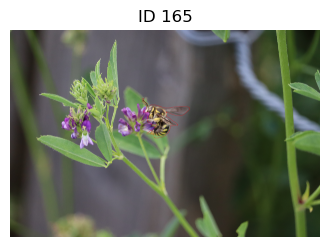

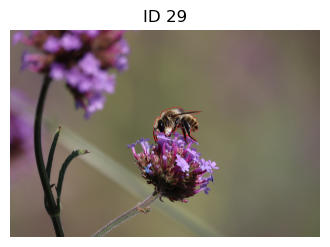

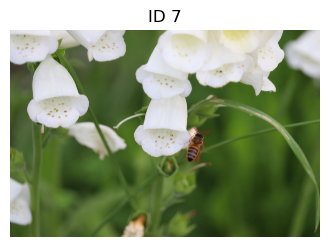

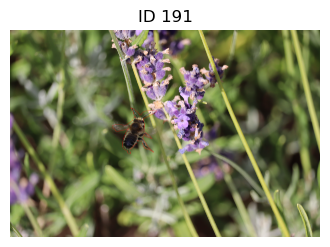

In [ ]:

ID_RE = re.compile(r'(\d+)')

def id_from_path(p: Path) -> int:
    m = ID_RE.search(p.stem)
    if not m:
        raise ValueError(f"ID introuvable dans {p.name}")
    return int(m.group(1))

def load_image(path: Path):
    img = cv2.imread(str(path))
    if img is None:
        raise ValueError(f"Impossible de lire {path}")
    return img[:, :, ::-1]  # BGR->RGB

def load_mask(path: Path):
    m = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise ValueError(f"Impossible de lire {path}")
    return (m > 0).astype(np.uint8)

def pair_dict(files):
    return {id_from_path(p): p for p in files}

img_by_id = pair_dict(img_files)
msk_by_id = pair_dict(msk_files)
common_ids = sorted(set(img_by_id) & set(msk_by_id))
print("Paires image+masque:", len(common_ids))

def show_samples(ids=None, n=6):
    if ids is None:
        ids = random.sample(common_ids, min(n, len(common_ids)))
    n = len(ids)
    for i, _id in enumerate(ids, 1):
        img = load_image(img_by_id[_id])
        msk = load_mask(msk_by_id[_id])
        plt.figure(figsize=(4,3))
        plt.imshow(img)
        # overlay masque en bordure (sans couleur forcée)
        cnts, _ = cv2.findContours(msk.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        overlay = img.copy()
        cv2.drawContours(overlay, cnts, -1, (255,0,0), 2)  # la couleur exacte dépendra de backend
        plt.imshow(overlay)
        plt.title(f"ID { _id }")
        plt.axis('off')
        plt.show()

show_samples(n=min(6, len(common_ids)))


In [6]:

# Vérifier compatibilité tailles + caractère binaire des masques
records = []
for _id in common_ids:
    ip, mp = img_by_id[_id], msk_by_id[_id]
    img = load_image(ip); msk = load_mask(mp)
    h,w,_ = img.shape; hm,wm = msk.shape
    same_size = (h==hm) and (w==wm)
    bin_ratio = float((msk==1).mean())
    records.append({'id': _id, 'image': str(ip), 'mask': str(mp),
                    'same_size': same_size, 'mask_coverage': bin_ratio})
df_checks = pd.DataFrame(records).sort_values('id')
df_checks.head()


KeyError: 'id'

In [7]:

problems = df_checks[~df_checks['same_size']]
print("Problèmes de dimensions:", len(problems))
if len(problems):
    display(problems.head(10))


NameError: name 'df_checks' is not defined

In [8]:

OUTPUTS = Path('outputs'); OUTPUTS.mkdir(exist_ok=True, parents=True)
df_checks.to_csv(OUTPUTS/'sanity_checks.csv', index=False)
print("Sauvegardé ->", OUTPUTS/'sanity_checks.csv')


NameError: name 'df_checks' is not defined

In [9]:

if LABELS_XLSX.exists():
    labels = pd.read_excel(LABELS_XLSX)
    labels.columns = [c.strip().lower().replace(' ','_') for c in labels.columns]
    if 'id' not in labels.columns:
        raise ValueError("La feuille labels doit contenir une colonne 'id'")
    df = df_checks.merge(labels, on='id', how='left')
    missing = df[df['bug_type'].isna()]
    print("Lignes sans label:", len(missing))
    display(df.head())
    # Répartition des classes
    if 'bug_type' in df.columns:
        ax = df['bug_type'].value_counts().sort_index().plot(kind='bar', figsize=(6,3), title='Répartition des bug types')
        plt.tight_layout(); plt.show()
else:
    print("Aucun fichier labels.xlsx trouvé (mode test/inférence).")


Aucun fichier labels.xlsx trouvé (mode test/inférence).


In [10]:

# Manifeste utilisable pour les notebooks suivants
manifest_cols = ['id', 'image', 'mask']
if LABELS_XLSX.exists():
    manifest_cols += ['bug_type', 'species'] if 'species' in labels.columns else ['bug_type']
manifest = df_checks.merge(labels, on='id', how='left') if LABELS_XLSX.exists() else df_checks
manifest = manifest[manifest_cols].sort_values('id')
manifest.to_csv(OUTPUTS/'dataset_manifest.csv', index=False)
manifest.head()


NameError: name 'df_checks' is not defined


## Étapes suivantes
- Extraire des **features** (couleur, forme, texture, symétrie) dans `01_features_build.ipynb`.
- Visualiser PCA/t‑SNE/UMAP et entraîner les modèles dans `02_viz_models.ipynb`.
- Générer le CSV de soumission dans `03_inference_to_csv.ipynb`.
